In [2]:
using NBInclude
@nbinclude("functions.ipynb")

All function imported


In [3]:
#setup
x_dim = 784
k = 20
epoch_to_load = 16 # Load the model 
tolerance = 1e-7; max_iter = 3000; out_toggle = 0
trials = 20
opt = Flux.Optimise.ADAM(.1);


dir = "trained_GNN/MNIST_identity"
encoder_μ, encoder_logvar, decoder, B = load_model_identity(dir, epoch_to_load)

_, _, decoder = load_model("trained_GNN/MNIST", 20)
A = Flux.params(decoder)[3]
z = randn(k) # ground code vector
F = dct(diagm(ones(x_dim)),2);

β_list, α_list = get_β_α(F, A, B, 21);
m_list = 20:20:440
# setup
# experiments with MNIST dataset

UndefVarError: UndefVarError: load_model_identity not defined

In [41]:
phase_matrix_recovery = zeros(trials, length(m_list), length(β_list))
phase_matrix_recon = zeros(trials, length(m_list), length(β_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    recovery_error_matrix = zeros(trials)
    recon_error_matrix = zeros(trials)
    for β in β_list
        recovery_error_list = []
        recon_error_list = []
        G = Chain(
            Dense(20, 500, relu, bias = false; init =(out,in) -> Flux.params(decoder)[1]),
            Dense(500, 500, relu, bias = false; init =(out,in) -> Flux.params(decoder)[2]),
            Dense(500, 784, identity, bias = false; init =(out,in) -> β * A + (1 - β) *B),
        )      #setup the generative network 

        Threads.@threads for trials in 1:trials
            F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
            F_sub = F_sub * sqrt(x_dim)/sqrt(m) #normalization          
            y = F_sub * G(z) # measurement vector using subsampled DCT matrix

            z_est = randn(k) #initialization for algorithm
            z_est = estimated_code(opt, G, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem

            push!(recovery_error_list, relative_error(z, z_est))    
            push!(recon_error_list, relative_error(G(z), G(z_est)))
        end

        recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
        recon_error_matrix = hcat(recon_error_matrix, recon_error_list)
    end
    phase_matrix_recovery[:, i, :] = recovery_error_matrix[:, 2:end]
    phase_matrix_recon[:, i, :] = recon_error_matrix[:, 2:end]
    println("Done with m = $m")
println("")
# end

Done with m = 20



In [4]:
# save("saved_data/Phase_plot_full_MNIST.jld", "phase_matrix_recovery", phase_matrix_recovery, "phase_matrix_recon", phase_matrix_recon, "α_list", α_list, "m_list", m_list, "trials", trials)
phase_matrix_recovery =load("saved_data/Phase_plot_full_MNIST.jld", "phase_matrix_recovery")
phase_matrix_recon =load("saved_data/Phase_plot_full_MNIST.jld", "phase_matrix_recon")
α_list =load("saved_data/Phase_plot_full_MNIST.jld", "α_list")
m_list =load("saved_data/Phase_plot_full_MNIST.jld", "m_list")
trials =load("saved_data/Phase_plot_full_MNIST.jld", "trials")

20

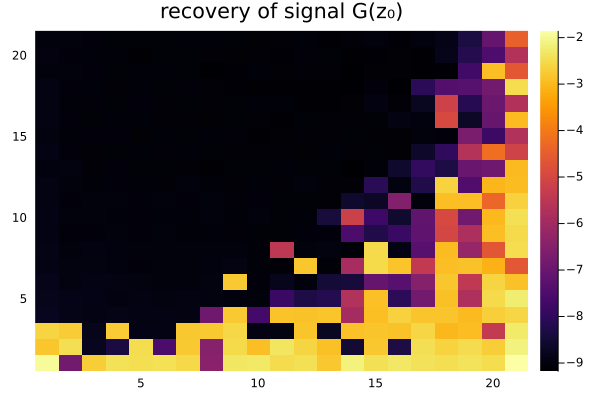

In [24]:



M = zeros(size(phase_matrix_recon[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-5)
end

# p1 = plot(colorview(Gray, reverse(M/trials, dims = 1)), bg =:black, title = "recovery of signal G(z₀)",framestyle = :box)
# xticks = 1:5:length(α_list)
plot(heatmap(M/trials),bg =:white, title = "recovery of signal G(z₀)",framestyle = :box, showaxis =:false)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[i])" for i in 2:5:length(m_list)])

M = sum(phase_matrix_recon,dims =1)[1,:,:]/20; M[M .>1] .= 1
plot(heatmap(log10.(M/trials)),bg =:white, title = "recovery of signal G(z₀)",framestyle = :box, showaxis =:false)


# p2 = plot(colorview(Gray, log10.(reverse(M,dims=1))), framestyle = :box, title = "recovery of signal G(z₀)")
# xticks = 1:5:length(α_list)
# xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
# yticks = 2:5:length(m_list)
# yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])


# plot(p1, p2, layout = 2, xlabel = "incoherence upper bound", ylabel = "number of measurements")
# savefig("figures/Phase_plot_Full_MNIST_percentage.pdf")
# log10.(M)
# M


In [5]:
phase_matrix_recon

20×21×21 Array{Float64, 3}:
[:, :, 1] =
 8.64186e-8  4.39277e-8  1.90508e-8  …  1.89398e-8  2.30266e-8  2.39682e-8
 8.15031e-8  3.67486e-8  4.22602e-8     2.26803e-8  1.88274e-8  1.3716e-8
 2.35392e-6  3.4925e-8   3.62315e-8     1.80434e-8  2.1047e-8   1.79433e-8
 3.64391e-7  4.37682e-8  2.84765e-8     2.20318e-8  2.39239e-8  1.22429e-8
 4.13871e-8  5.6638e-8   3.17914e-8     1.67353e-8  1.78364e-8  2.49379e-8
 5.09561e-8  3.22289e-8  2.75189e-8  …  2.78837e-8  2.31413e-8  1.75904e-8
 7.91541e-8  4.39352e-8  4.60166e-8     2.051e-8    1.96559e-8  1.61951e-8
 1.06128     4.11773e-8  3.95664e-8     1.62457e-8  1.86769e-8  1.97451e-8
 0.971729    3.20826e-8  3.27353e-8     1.67576e-8  2.08252e-8  2.04983e-8
 4.87521e-8  7.29485e-8  4.29321e-8     1.61733e-8  1.45338e-8  6.32523e-9
 5.81358e-8  4.38597e-8  4.14472e-8  …  1.50417e-8  1.97382e-8  2.13363e-8
 8.69347e-8  3.74213e-8  2.68606e-8     1.54209e-8  1.92193e-8  3.31087e-8
 9.42238e-8  4.06258e-8  3.04588e-8     1.50943e-8  1.62191e-

In [95]:


M = sum(phase_matrix_recovery,dims =1)[1,:,:]/20; M[M .>1] .= 1
p1 = plot(colorview(Gray, reverse(M,dims=1)), framestyle = :box, bg =:black, title = "recovery of code z₀")
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])

M = sum(phase_matrix_recon,dims =1)[1,:,:]/20; M[M .>1] .= 1
p2 = plot(colorview(Gray, reverse(M,dims=1)), framestyle = :box, bg =:black, title = "recovery of signal G(z₀)")
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])

plot(p1, p2, layout = 2,  bg =:white)
savefig("figures/Phase_plot_Full_MNIST_error.pdf")



In [ ]:
M = zeros(size(phase_matrix_recovery[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-5)
end
p1 = plot(colorview(Gray, reverse(M/trials, dims = 1)), bg =:black, title = "recovery of code z₀", framestyle = :box)
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])

# m_pred = 600*α_list.^10
# ff(x) = -21/420 * x +(1 + 21*440/420)
# plot!(1:length(α_list), ff.(m_pred), label =:false, linewidth = 2 )

# m_pred = 150*α_list.^3
# plot!(1:length(α_list), ff.(m_pred), label =:false, linewidth = 2 )